<a href="https://colab.research.google.com/github/LeNovice/PSW/blob/main/CadenceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO: Refer

https://debuggercafe.com/getting-95-accuracy-on-the-caltech101-dataset-using-deep-learning/

Loading the Caltech Dataset

In [1]:
import tensorflow_datasets as tfds
import numpy as np
#For plotting the dataset
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
#Data pipeline preparation
import tensorflow as tf
from tensorflow.keras import layers
#model building
from tensorflow.keras import models

In [2]:
#(ds, ds_info) = tfds.load('caltech101', with_info=True)
#display(ds_info)
dataset_builder = tfds.builder("caltech101")
dataset_builder.download_and_prepare()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3060 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/3.0.1.incompleteAS3QOA/caltech101-train.tfrecord*...:   0%|    …

Generating test examples...:   0%|          | 0/6084 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/3.0.1.incompleteAS3QOA/caltech101-test.tfrecord*...:   0%|     …

Dataset caltech101 downloaded and prepared to /root/tensorflow_datasets/caltech101/3.0.1. Subsequent calls will reuse this data.


Data Preprocessing

We could use adapt() methods to get normlazation (feature wise) parameters. https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method

https://stackoverflow.com/questions/57657386/tensorflow-datasets-reshape-images

In [11]:
IMG_SIZE = 224
NUM_CHANNELS = 3

"""
train_data_np = tfds.as_numpy(ds["train"])
#display(train_data_np)
for a in train_data_np:
    display(a["image"].shape)
    break
train_data_resized = tf.image.resize(train_data_np, [IMG_SIZE, IMG_SIZE, NUM_CHANNELS])
"""

train_data = dataset_builder.as_dataset(split=tfds.Split.TRAIN)     #train_data = dataset_builder.as_dataset(split=tfds.Split.TRAIN)
#train_data = tfds.as_numpy(train_data)

#display(train_data)

train_data_x = train_data.map(lambda image: tf.image.resize_with_crop_or_pad(image["image"], 224, 224))
train_data_x_np = tfds.as_numpy(train_data_x)
train_data_y = train_data.map(lambda label: label["label"])
train_data_y_np = tfds.as_numpy(train_data_y)

display(type(train_data_x_np))
train_data_x = [image for image in train_data_x_np]
display(type(train_data_x))
train_data_y = [label for label in train_data_y_np]
#display(train_data_y)
#ds_train = train_data.map(lambda image: tf.image.resize_with_crop_or_pad(image, 224, 224))
#
#ds_test = ds["test"]

tensorflow_datasets.core.dataset_utils._IterableDataset

list

display few examples

In [12]:
classes_ID = np.unique(train_data_y)
data_class_acc_class = []
for class_id in classes_ID:
    data_class_acc_class.append([i for i,x in enumerate(train_data_y) if x == class_id])


rows = len(classes_ID)
columns = 2
display(rows)
display(columns)

102

2

In [13]:
display(type(classes_ID))

numpy.ndarray

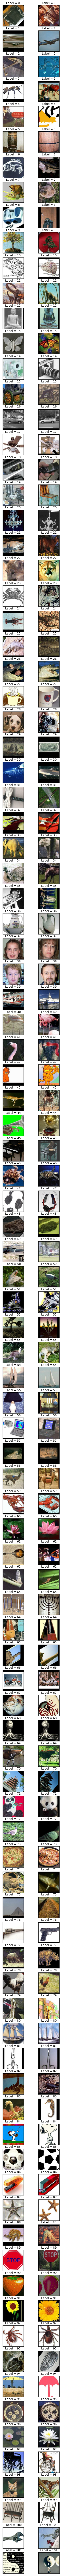

In [14]:


fig = plt.figure(figsize=(5,200))
i_ax =0
for class_id  in classes_ID:
    fig.add_subplot(rows, columns, i_ax+1)
    plt.imshow(train_data_x[data_class_acc_class[class_id][0]])
    plt.xticks([])      #Does not clutter the axes
    plt.yticks([])
    plt.title("Label = " + str(class_id))
    i_ax = i_ax + 1
    fig.add_subplot(rows, columns, i_ax+1)
    plt.imshow(train_data_x[data_class_acc_class[class_id][1]])
    plt.xticks([])      #Does not clutter the axes
    plt.yticks([])
    plt.title("Label = " + str(class_id))
    i_ax = i_ax + 1

plt.show()

input_shape = train_data_x[data_class_acc_class[class_id][0]].shape

In [15]:
input_shape

(224, 224, 3)

In [18]:
#ds_example = ds_train.take(10)
#fig = tfds.show_examples(train_data_x, ds_info)

Resizing and re-scaling images to a given dataset.
Tutorial used: https://www.tensorflow.org/tutorials/images/data_augmentation

For data pipeline you may also refer to
https://github.com/tensorflow/datasets/issues/720

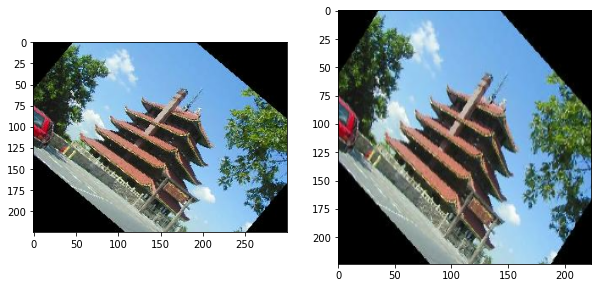

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (224, 224, 3)             0         
                                                                 
 rescaling (Rescaling)       (224, 224, 3)             0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


None

In [16]:


#cfg file NHWC format
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

example_ds = train_data.take(1)
for example in example_ds:
    ds_train_resized = resize_and_rescale(example["image"])

fig = plt.figure(figsize=(10,10))
fig.add_subplot(1, 2, 1)
plt.imshow(example["image"])
fig.add_subplot(1, 2, 2)
plt.imshow(ds_train_resized)

plt.show()
display(resize_and_rescale.summary())
#fig = tfds.show_examples(ds_train_resized, ds_info)

Prepare the model
For Batchnorm, refer https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization

Here they say that During training, the layer normalizes its output using the mean and standard deviation of the **current batch** of inputs.

In order to make BatchNorm great, should we be using a larger batch as input?

However, during Inference mode, the mean ans tsd deviation does not correspond to the current batch. Rather it is a moving mean and std dev of all the bacthes seen in training phase. (Thus, the parameters in inference phase for batch norm do not change)

In [17]:
model = models.Sequential()
#model.add(resize_and_rescale)

kernel_size = (5,5)
model.add(layers.Conv2D(64, kernel_size, input_shape = input_shape))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
model.add(layers.BatchNormalization())
pool_size = (2,2)
model.add(layers.MaxPool2D(pool_size))

kernel_size = (3,3)
model.add(layers.Conv2D(192, kernel_size))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
model.add(layers.BatchNormalization())
pool_size = (2,2)
model.add(layers.MaxPool2D(pool_size))

kernel_size = (3,3)
model.add(layers.Conv2D(64, kernel_size))       #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
model.add(layers.BatchNormalization())
pool_size = (2,2)
model.add(layers.MaxPool2D(pool_size))

kernel_size = (3,3)
model.add(layers.Conv2D(128, kernel_size))      #TODO: For instance, after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
model.add(layers.BatchNormalization())
pool_size = (2,2)
model.add(layers.MaxPool2D(pool_size))

model.add(layers.Flatten())
model.add(layers.Dense(10, activation='softmax'))

In [18]:
Learning_Rate = 1e-1                                            #https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
opt = tf.keras.optimizers.Adam(learning_rate=Learning_Rate)     #OR tf.keras.optimizers.SGD(learning_rate=Learning_Rate, momentum=0.0)
model.compile( optimizer = opt, loss = 'categorical_crossentropy', metrics=['accuracy'] )

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 192)     110784    
                                                                 
 batch_normalization_1 (Batc  (None, 108, 108, 192)    768       
 hNormalization)                                                 
                                                      

Reference: https://github.com/tensorflow/datasets/issues/720

In [20]:
"""np_ds_train = tfds.as_numpy(ds_train)
np_ds_test = tfds.as_numpy(ds_test)

x_train, y_train = np_ds_train["image"], np_ds_train["label"]
x_test, y_test = np_ds_test["image"], np_ds_test["label"]
"""
h = model.fit( train_data_x, train_data_y, epochs=25, batch_size=64)

ValueError: ignored